In [1]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2024-04-07 23:01:36--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.177.37, 52.217.206.192, 52.217.119.112, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.177.37|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  45.3MB/s    in 0.3s    

2024-04-07 23:01:36 (45.3 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

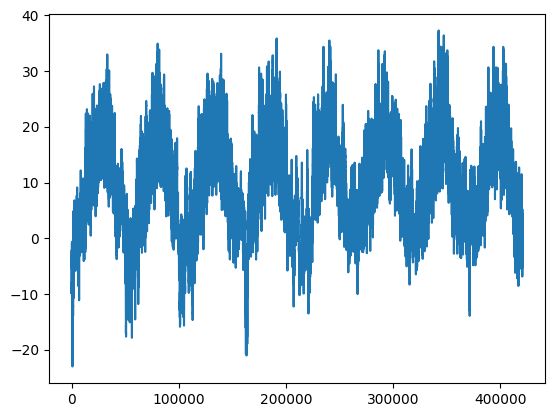

In [4]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

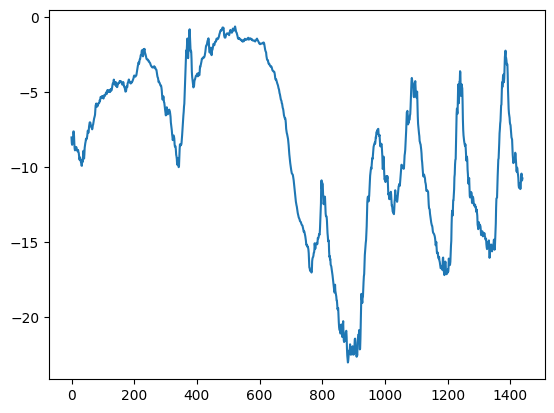

In [5]:
plt.plot(range(1440), temperature[:1440])

In [6]:

num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [7]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


In [9]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [10]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [11]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [12]:
import keras
from keras import layers

In [ ]:
import keras
from keras import layers
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)
outputs = layers.SimpleRNN(32)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 368s 442ms/step - loss: 25.8899 - mae: 3.7381 - val_loss: 9.9476 - val_mae: 2.4428
Epoch 2/10
819/819 [==============================] - 361s 440ms/step - loss: 13.9303 - mae: 2.8923 - val_loss: 9.0996 - val_mae: 2.3391
Epoch 3/10
819/819 [==============================] - 359s 438ms/step - loss: 13.2741 - mae: 2.8209 - val_loss: 8.8474 - val_mae: 2.3115
Epoch 4/10
819/819 [==============================] - 361s 441ms/step - loss: 12.6623 - mae: 2.7580 - val_loss: 8.8146 - val_mae: 2.3040
Epoch 5/10
819/819 [==============================] - 355s 434ms/step - loss: 12.1400 - mae: 2.7035 - val_loss: 8.8134 - val_mae: 2.3077
Epoch 6/10
819/819 [==============================] - 358s 437ms/step - loss: 11.7021 - mae: 2.6564 - val_loss: 8.8937 - val_mae: 2.3184
Epoch 7/10
819/819 [==============================] - 357s 436ms/step - loss: 11.3273 - mae: 2.6124 - val_loss: 8.7499 - val_mae: 2.3101
Epoch 8/10
819/819 [=====================

In [18]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 simple_rnn_6 (SimpleRNN)    (None, 120, 32)           1504      
                                                                 
 simple_rnn_7 (SimpleRNN)    (None, 120, 32)           2080      
                                                                 
 simple_rnn_8 (SimpleRNN)    (None, 32)                2080      
                                                                 
Total params: 5664 (22.12 KB)
Trainable params: 5664 (22.12 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


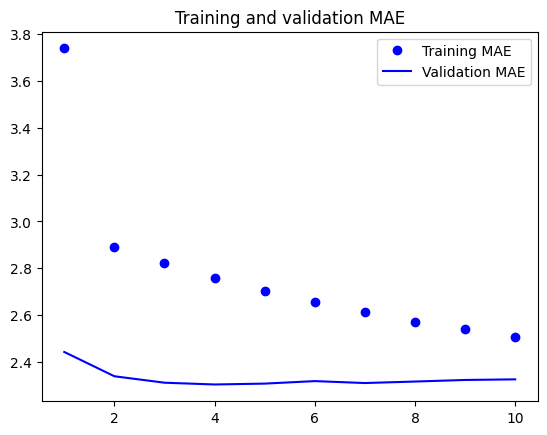

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 26s 63ms/step - loss: 9.7188 - mae: 2.4516
Test MAE: 2.45


In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/10
819/819 [==============================] - 265s 316ms/step - loss: 38.8443 - mae: 4.6141 - val_loss: 11.9924 - val_mae: 2.6131
Epoch 2/10
819/819 [==============================] - 248s 303ms/step - loss: 18.4798 - mae: 3.2918 - val_loss: 9.4896 - val_mae: 2.3850
Epoch 3/10
819/819 [==============================] - 250s 305ms/step - loss: 17.1136 - mae: 3.1729 - val_loss: 9.0011 - val_mae: 2.3314
Epoch 4/10
819/819 [==============================] - 260s 317ms/step - loss: 16.3446 - mae: 3.1004 - val_loss: 9.0883 - val_mae: 2.3418
Epoch 5/10
819/819 [==============================] - 257s 314ms/step - loss: 15.7560 - mae: 3.0505 - val_loss: 8.9476 - val_mae: 2.3263
Epoch 6/10
819/819 [==============================] - 262s 319ms/step - loss: 15.1642 - mae: 2.9957 - val_loss: 8.9392 - val_mae: 2.3297
Epoch 7/10
819/819 [==============================] - 254s 310ms/step - loss: 14.7593 - mae: 2.9585 - val_loss: 9.0314 - val_mae: 2.3340
Epoch 8/10
819/819 [====================

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 120, 16)           496       
                                                                 
 simple_rnn_4 (SimpleRNN)    (None, 120, 16)           528       
                                                                 
 simple_rnn_5 (SimpleRNN)    (None, 16)                528       
                                                                 
Total params: 1552 (6.06 KB)
Trainable params: 1552 (6.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


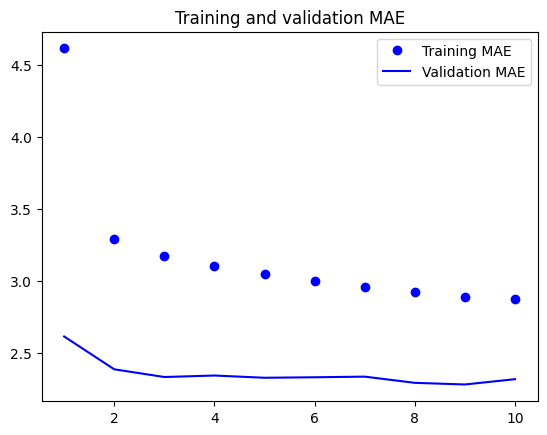

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 34s 80ms/step - loss: 9.8089 - mae: 2.4404
Test MAE: 2.44


In [ ]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(64, return_sequences=True)(inputs)
x = layers.SimpleRNN(64, return_sequences=True)(x)
outputs = layers.SimpleRNN(64)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)


Epoch 1/10
819/819 [==============================] - 601s 728ms/step - loss: 17.1257 - mae: 3.1147 - val_loss: 9.6111 - val_mae: 2.4100
Epoch 2/10
819/819 [==============================] - 610s 745ms/step - loss: 11.5254 - mae: 2.6441 - val_loss: 9.6880 - val_mae: 2.4070
Epoch 3/10
819/819 [==============================] - 608s 742ms/step - loss: 10.6118 - mae: 2.5428 - val_loss: 8.9212 - val_mae: 2.3195
Epoch 4/10
819/819 [==============================] - 609s 743ms/step - loss: 9.8728 - mae: 2.4503 - val_loss: 9.2913 - val_mae: 2.3753
Epoch 5/10
819/819 [==============================] - 609s 743ms/step - loss: 9.1524 - mae: 2.3582 - val_loss: 10.0281 - val_mae: 2.4670
Epoch 6/10
819/819 [==============================] - 603s 736ms/step - loss: 8.5514 - mae: 2.2766 - val_loss: 10.6161 - val_mae: 2.5315
Epoch 7/10
819/819 [==============================] - 609s 743ms/step - loss: 8.0276 - mae: 2.2020 - val_loss: 10.8332 - val_mae: 2.5605
Epoch 8/10
819/819 [======================

In [20]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 120, 14)]         0         
                                                                 
 simple_rnn_9 (SimpleRNN)    (None, 120, 64)           5056      
                                                                 
 simple_rnn_10 (SimpleRNN)   (None, 120, 64)           8256      
                                                                 
 simple_rnn_11 (SimpleRNN)   (None, 64)                8256      
                                                                 
Total params: 21568 (84.25 KB)
Trainable params: 21568 (84.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


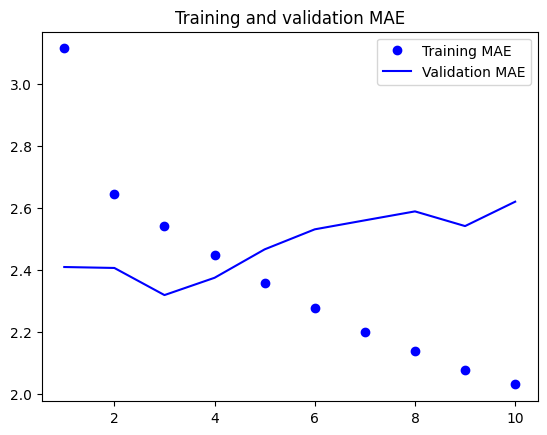

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 71s 172ms/step - loss: 9.4612 - mae: 2.4166
Test MAE: 2.42


In [ ]:
from tensorflow import keras
from keras import layers
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)


Epoch 1/10
819/819 [==============================] - 125s 150ms/step - loss: 40.7686 - mae: 4.6548 - val_loss: 12.4639 - val_mae: 2.7032
Epoch 2/10
819/819 [==============================] - 122s 149ms/step - loss: 11.2581 - mae: 2.6018 - val_loss: 9.4821 - val_mae: 2.4058
Epoch 3/10
819/819 [==============================] - 124s 151ms/step - loss: 9.8722 - mae: 2.4495 - val_loss: 9.6263 - val_mae: 2.4207
Epoch 4/10
819/819 [==============================] - 121s 148ms/step - loss: 9.4902 - mae: 2.4036 - val_loss: 9.5964 - val_mae: 2.4117
Epoch 5/10
819/819 [==============================] - 102s 125ms/step - loss: 9.1954 - mae: 2.3683 - val_loss: 9.7148 - val_mae: 2.4237
Epoch 6/10
819/819 [==============================] - 121s 148ms/step - loss: 9.0297 - mae: 2.3457 - val_loss: 9.8335 - val_mae: 2.4306
Epoch 7/10
819/819 [==============================] - 123s 149ms/step - loss: 8.9224 - mae: 2.3292 - val_loss: 9.6723 - val_mae: 2.4236
Epoch 8/10
819/819 [=========================

In [ ]:
model.evaluate(test_dataset)

405/405 [==============================] - 25s 62ms/step - loss: 10.3097 - mae: 2.5310


[10.309748649597168, 2.531005382537842]

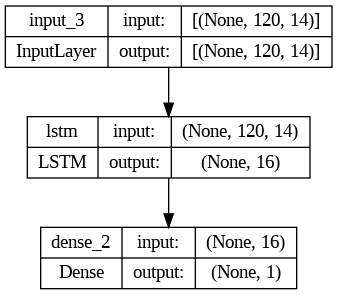

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

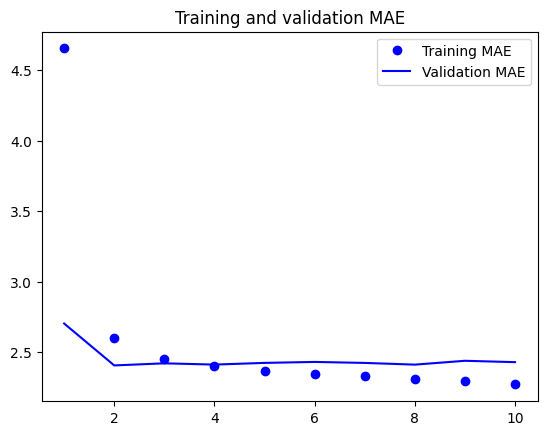

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
input_shape = (120, 14)
inputs = keras.Input(shape=input_shape)
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.LSTM(32, return_sequences=True)(x)
x = layers.GlobalAveragePooling1D()(x)
x=layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)
model.evaluate(test_dataset)

Epoch 1/10
819/819 [==============================] - 96s 114ms/step - loss: 30.6561 - mae: 4.2304 - val_loss: 15.7040 - val_mae: 3.1018
Epoch 2/10
819/819 [==============================] - 89s 108ms/step - loss: 18.5964 - mae: 3.3805 - val_loss: 14.8957 - val_mae: 3.0269
Epoch 3/10
819/819 [==============================] - 94s 115ms/step - loss: 16.6534 - mae: 3.1880 - val_loss: 15.0391 - val_mae: 3.0454
Epoch 4/10
819/819 [==============================] - 91s 111ms/step - loss: 15.4359 - mae: 3.0601 - val_loss: 14.0168 - val_mae: 2.9486
Epoch 5/10
819/819 [==============================] - 92s 112ms/step - loss: 14.4679 - mae: 2.9530 - val_loss: 15.7505 - val_mae: 3.1316
Epoch 6/10
819/819 [==============================] - 90s 109ms/step - loss: 13.6625 - mae: 2.8600 - val_loss: 16.6693 - val_mae: 3.2237
Epoch 7/10
819/819 [==============================] - 95s 116ms/step - loss: 13.0161 - mae: 2.7885 - val_loss: 15.7926 - val_mae: 3.1268
Epoch 8/10
819/819 [=====================

[20.028507232666016, 3.485621213912964]

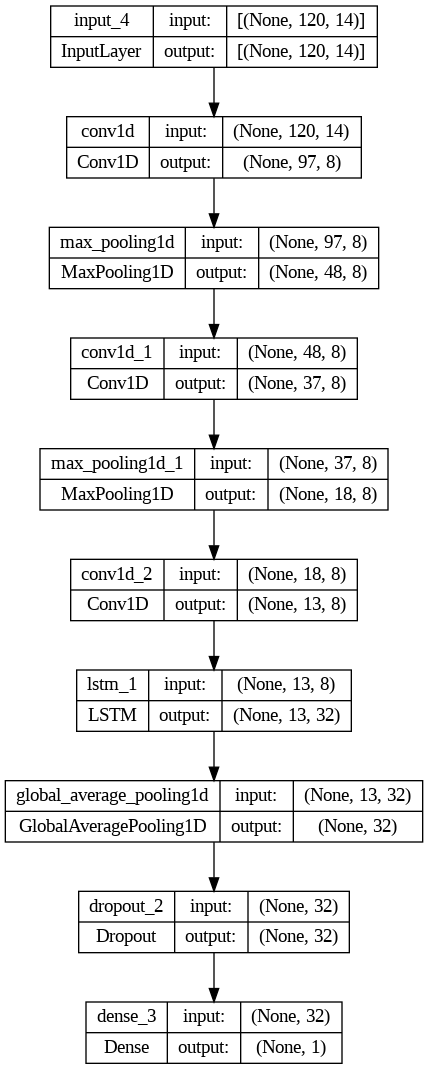

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

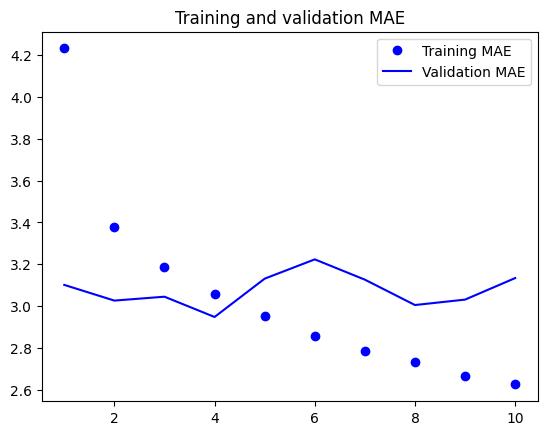

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)
model.evaluate(test_dataset)

Epoch 1/10
819/819 [==============================] - 155s 185ms/step - loss: 25.0062 - mae: 3.5911 - val_loss: 10.0301 - val_mae: 2.4489
Epoch 2/10
819/819 [==============================] - 161s 197ms/step - loss: 9.2236 - mae: 2.3778 - val_loss: 10.2531 - val_mae: 2.4742
Epoch 3/10
819/819 [==============================] - 163s 198ms/step - loss: 8.1813 - mae: 2.2361 - val_loss: 10.5838 - val_mae: 2.5244
Epoch 4/10
819/819 [==============================] - 158s 193ms/step - loss: 7.5939 - mae: 2.1552 - val_loss: 10.9781 - val_mae: 2.5564
Epoch 5/10
819/819 [==============================] - 161s 196ms/step - loss: 7.0325 - mae: 2.0751 - val_loss: 11.3858 - val_mae: 2.5928
Epoch 6/10
819/819 [==============================] - 149s 182ms/step - loss: 6.6492 - mae: 2.0171 - val_loss: 11.9721 - val_mae: 2.6379
Epoch 7/10
819/819 [==============================] - 158s 193ms/step - loss: 6.3867 - mae: 1.9771 - val_loss: 12.1011 - val_mae: 2.6519
Epoch 8/10
819/819 [====================

[11.934633255004883, 2.7126948833465576]

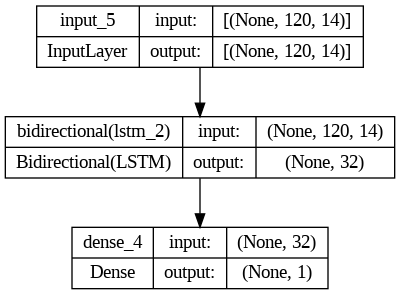

In [ ]:
keras.utils.plot_model(model, show_shapes=True)

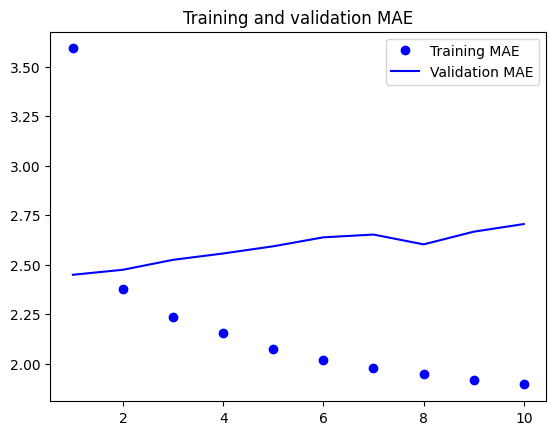

In [ ]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()